In [41]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
from einops import rearrange
from utils import evaluations as ev

import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1


    
    

def iter_list(log_dir):
    dirlist = os.listdir(log_dir)
    iterlist = []
    for mydir in dirlist:
        if 'iter' in mydir and 'tmp' not in mydir:
            iterlist.append(int(mydir.split('_')[-1]))
    return np.array(iterlist)
    
    
def load_model(model, log_dir, iters, latest=False):
    print(f"""{log_dir} \n snapshot_model_iter_{iters}""")
    if latest == True:
        iters = np.max(iter_list(log_dir))
    model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_model_iter_{}'.format(iters))))
    #model.load_state_dict(torch.load(os.path.join(log_dir, 'snapshot_manager_iter_{}'.format(iters))))




def load_config(targdir_path):
    targ_config_path = os.path.join(targdir_path, 'config.yml')
    with open(targ_config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config
    
    
def filter_names(query, mydict):
    filtered = {} 
    for key in mydict.keys():
        if query in key:
            filtered[key] = mydict[key]
    return filtered
    
def filter_list(query, mylist):
    filtered = [] 
    for key in mylist:
        if query in key:
            filtered.append(key)
    return filtered


def model_exists(targlist,  targpath):
    filtered_list = []
    for targdir in targlist:
        if os.path.exists(os.path.join(targpath, targdir, 'config.yml')):
            filtered_list.append(targdir)
    return filtered_list
    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'
jobdir = '/mnt/vol21/masomatics/ULASclone/jobs'

mode = 'so3'
dat_root = f"""/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/{mode}"""

baseline_path = os.path.join(result_dir, '20220615_default_run_mnist')
basestar_path = os.path.join(result_dir, '20220615_NeuralMstar_neuralM_vanilla')
print(baseline_path)
print(os.path.exists(baseline_path))
print(os.path.exists(basestar_path))


filter_list('202209', os.listdir(result_dir))

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist
True
True


['20220901_Mstar_inv_reg_cnn_0',
 '20220908_lstsq_Mdetach_0',
 '20220909_latentPredict_zero_0',
 '20220908_latentPredict_bg_0',
 '20220901_Mstar_orth_0',
 '20220907_latentPredict_0']

In [42]:
#projname = 'latentPredict'
projname =  'lstsq_Mdetach'
#setting_name = '_'.join(np.sort(filter_list(projname, os.listdir(jobdir)))[0].split('_')[:-1])
setting_name = (np.sort(filter_list(projname, os.listdir(jobdir)))[0]).split('_')[0]

print(setting_name)
filter_list(projname, os.listdir(result_dir))


20220908


['20220908_lstsq_Mdetach_0']

In [43]:
#targdir = '20220824_MstarRemoveXa_0' 
#targdir = '20220826_Mstar_orth_0'
#targdir = '20220830_Mstar_orth_0'
#targdir  =  '20220829_Mstar_inv_reg_cnn_0'

#projname = 'Mstar_orth_mlp_two' 
targdir = f'''20220908_{projname}_0'''
#jobpath =f'''../jobs/20220829_{projname}'''
jobpath = f'''../jobs/{setting_name}_{projname}'''
print(jobpath)
print(os.path.exists(jobpath))
#jobpath = os.path.join('../jobs/','_'.join(targdir.split('_')[:-1]))


targpath = os.path.join(result_dir, targdir)
targlist = os.listdir(targpath)

targlist = model_exists(targlist,  targpath)
print(targlist)

../jobs/20220908_lstsq_Mdetach
True
['detachM0', 'detachM1']


['detachM0', 'detachM1']
2.5627522331476214
12.262603989601136


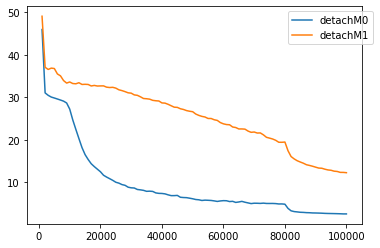

In [44]:
print(os.listdir(targpath))

resultlist = os.listdir(targpath)



from utils import notebook_utils as nb
reload(nb)



for result in resultlist:
    studypath = os.path.join(targpath, result)
    history = nb.read_history(studypath)
    if len(history) > 0:
        plt.plot(history['iteration'], history['train/loss'], label = result)
        print(history['train/loss'][-1])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.savefig(os.path.join(jobpath, f"""{targdir}_learning.png"""))

In [46]:
reload(ev)
results = {} 
inferred_Ms = {} 
model_configs = {}
models = {}
tp = 8
n_cond = 2
device =0
predictive = False
reconstructive = True

targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 
#targdir_pathlist = []
targdir_pathlist.append(basestar_path)
targdir_pathlist.append(baseline_path)


for targdir_path in targdir_pathlist:
    
    Mlist = [] 
    config = load_config(targdir_path)
    
    dataconfig = config['train_data']
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])

    model_config = config['model']
    model = yu.load_component(model_config)
    iterlist = iter_list(targdir_path)
    if len(iterlist) == 0:
        print(f"""There is no model trained for {targdir_path}""")
    else:
        #maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        images = iter(train_loader).next()

        # Initialize lazy modules
        if type(images) == list:
            images = torch.stack(images)
            images = images.transpose(1, 0)        
        images = images.to(device)
        if str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0] == 'SeqAENeuralM_latentPredict':
            model.conduct_prediction(images[:, :n_cond], n_rolls=tp)
        else:
            model(images[:, :n_cond])
            
            
        with torch.no_grad():
            scores = [] 
            l2scores = []
            for images in tqdm(train_loader):
                if type(images) == list:
                    images = torch.stack(images)
                    images = images.transpose(1, 0)
                # n t c w h
                images = images.to(device)
                images_cond = images[:, :n_cond]
                if predictive == True or reconstructive == True:
                    images_target = images
                else:
                    images_target = images[:, n_cond:n_cond+tp]
                x_next, M = ev.predict(images, model, n_cond=n_cond, tp=tp, device=device, predictive=predictive, reconstructive=reconstructive)
 
                r2_losses = [] 
                l2_losses = []
                for k in range(tp):
                    
                    images_target_vec = rearrange(images_target, 'n t c w h -> n t (c w h)')
                    x_next_vec = rearrange(x_next, 'n t c w h -> n t (c w h)')
                    #r2_loss_t = r2_score(images_target_vec[:,k].to('cpu').numpy(), x_next_vec[:,k].to('cpu').numpy()) 
                    l2_loss_t = torch.sqrt(torch.sum((images_target[:, k].to('cpu') - x_next[:, k].to('cpu'))**2, axis=[1,2,3]))
                    l2_loss_t = torch.mean(l2_loss_t)
                    #r2_losses.append(r2_loss_t)
                    l2_losses.append(l2_loss_t)

                scores.append(torch.tensor(r2_losses))
                l2scores.append(torch.tensor(l2_losses))

                Mlist.append(M)
        
                
        Mlist = torch.cat(Mlist)       
        scores = torch.stack(scores)
        #av_score = torch.mean(scores, axis=0)
        #av_var = torch.var(scores, axis=0)
        
        l2scores = torch.stack(l2scores)
        av_l2 = torch.mean(l2scores, axis=0)
        av_l2var = torch.var(l2scores, axis=0)
        print(av_l2)
        
        #results[targdir_path] = [av_score, av_var, av_l2, av_l2var]
        results[targdir_path] = [av_l2, av_l2var]


        inferred_Ms[targdir_path] = Mlist
        models[targdir_path] = model.to('cpu')
        model_configs[targdir_path] = model_config


    

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220908_lstsq_Mdetach_0/detachM0 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:12<00:00, 14.29it/s]


tensor([2.3297, 2.2494, 2.8502, 4.5133, 6.0018, 6.9658, 7.6283, 8.1543])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220908_lstsq_Mdetach_0/detachM1 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:13<00:00, 13.92it/s]


tensor([5.3690, 5.3874, 5.7473, 6.4238, 6.9983, 7.2089, 7.2971, 7.4234])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:12<00:00, 14.09it/s]


tensor([0.9737, 0.9510, 2.1509, 5.9206, 8.1741, 8.9073, 9.0984, 9.4328])
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:12<00:00, 14.85it/s]

tensor([2.0144, 1.9134, 2.6284, 4.6448, 6.2547, 7.2712, 7.9617, 8.4189])


In [47]:
results

{'/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220908_lstsq_Mdetach_0/detachM0': [tensor([2.3297, 2.2494, 2.8502, 4.5133, 6.0018, 6.9658, 7.6283, 8.1543]),
  tensor([0.0130, 0.0141, 0.0301, 0.1111, 0.1409, 0.1421, 0.1173, 0.1336])],
 '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220908_lstsq_Mdetach_0/detachM1': [tensor([5.3690, 5.3874, 5.7473, 6.4238, 6.9983, 7.2089, 7.2971, 7.4234]),
  tensor([0.0399, 0.0429, 0.0611, 0.0866, 0.0915, 0.0937, 0.0826, 0.0878])],
 '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla': [tensor([0.9737, 0.9510, 2.1509, 5.9206, 8.1741, 8.9073, 9.0984, 9.4328]),
  tensor([0.0017, 0.0016, 0.0377, 0.1131, 0.1496, 0.1248, 0.1214, 0.1830])],
 '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist': [tensor([2.0144, 1.9134, 2.6284, 4.6448, 6.2547, 7.2712, 7.9617, 8.4189]),
  tensor([0.0116, 0.0094, 0.0406, 0.1364, 0.1704, 0.1346, 0.1087, 0.1102])]}

In [48]:
images.shape

torch.Size([18, 10, 3, 32, 32])

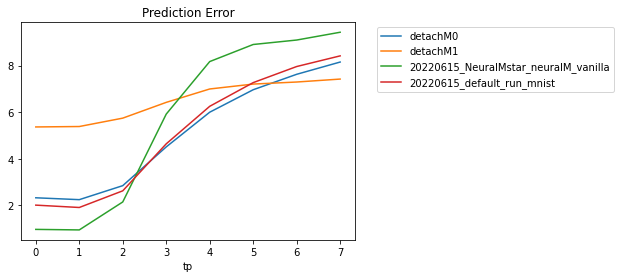

In [49]:
reload(nb)
showresults = []
#showresults = nb.filter_queries(['predictiveTrue', 'default', 'reg_obs10'] , list(results.keys()))
showresults = nb.filter_queries([''] , list(results.keys()))

#showresults.append(baseline_path)
#showresults.append(basestar_path)


for mode in showresults:
    plt.plot(results[mode][0], label=mode.split('/')[-1])
    plt.xlabel("tp")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.title("Prediction Error")

plt.savefig(os.path.join(jobpath, targdir+'l2loss.png'))


In [50]:
reload(ev)


def get_predict(targdir_path, swap=False, predictive=False):
    config = load_config(targdir_path)

    model_config = config['model']
    if len(iter_list(targdir_path)) > 0:
        maxiter = np.max(iter_list(targdir_path))
        model = yu.load_component(model_config).to(device)
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)
        #model(images[:, :2])
        if str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0] == 'SeqAENeuralM_latentPredict':
            model.conduct_prediction(images[:, :n_cond], n_rolls=tp)
        else:
            model(images[:, :n_cond])
        x_next, M = ev.predict(images, model, n_cond=n_cond, tp=tp, device=device, swap=swap, 
                              predictive=predictive)
        return x_next,M 
    else:
        return 0, 0



In [51]:
from models import seqae
import models
print(seqae.SeqAELSTSQ)
str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0]



<class 'models.seqae.SeqAELSTSQ'>


'SeqAELSTSQ'

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220908_lstsq_Mdetach_0/detachM0 
 snapshot_model_iter_100000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220908_lstsq_Mdetach_0/detachM1 
 snapshot_model_iter_100000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla 
 snapshot_model_iter_50000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000


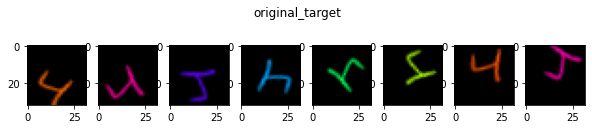

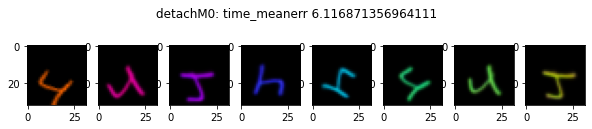

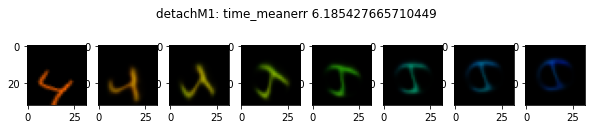

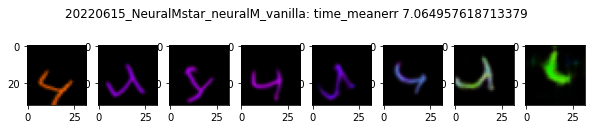

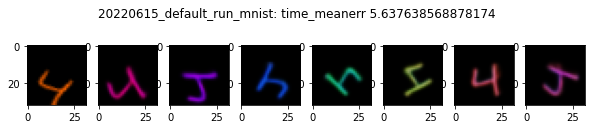

In [53]:
tp=8
idx = 0
predictive = True

images = data[idx]
if type(images) == list:
    images = torch.stack(images)
    images = images.unsqueeze(0)   
    images= images.to(device)

if predictive == True:
    images_target = images
else:
    images_target = images[:, n_cond:n_cond+tp]
    
plt.figure(figsize=(10,2))
for k in range(0,tp):
    plt.subplot(1,tp, k+1)
    plt.imshow(images_target[0][k].detach().to('cpu').permute([1,2, 0]))
    
plt.suptitle("original_target")
plt.savefig(os.path.join(jobpath, f"""{targdir}_realization_original.png"""))

#for j in range(len(targdir_pathlist)):'
for j in range(len(showresults)):
    #x_next, M = get_predict(targdir_pathlist[j], predictive=predictive)
    x_next, M = get_predict(showresults[j], predictive=predictive)
    if type(x_next) == int:
        pass
    else:
        #name = targdir_pathlist[j].split('/')[-1]
        name = showresults[j].split('/')[-1]
        err=0
        plt.figure(figsize=(10,2))
        for k in range(0,tp): 
            plt.subplot(1,tp, k+1)
            plt.imshow(x_next[0][k].detach().to('cpu').permute([1,2, 0]))
            err = err + torch.sqrt(torch.sum((x_next[0][k].to('cpu') - images_target[0][k].to('cpu'))**2))
        err = err / (k+1)
        plt.suptitle(f"""{name}: time_meanerr {err}""")
        plt.savefig(os.path.join(jobpath, f"""{targdir}_realization_{name}.png"""))

# x_next, M = get_predict(targlist[1])


# plt.figure()
# for k in range(0,tp): 
#     plt.subplot(1,tp, k+1)
#     plt.imshow(x_next[0][k].detach().to('cpu').permute([1,2, 0]))
# plt.title(targlist[1])






# Equivariance (this should be higher than prediction error, look over

In [13]:
equiv_results = {} 
inferred_Ms = {} 
tp = 8
n_cond = 2
#targdir_pathlist = [os.path.join(targpath, targdir) for targdir in targlist] 

for targdir_path in showresults:
    
    Mlist = [] 
    config = load_config(targdir_path)
    
    dataconfig = config['train_data']
    dataconfig['args']['shared_transition'] = 1
    dataconfig['args']['T'] = tp + n_cond
    
    data = yu.load_component(dataconfig)
    train_loader = DataLoader(data, 
                              batch_size=config['batchsize'],
                              shuffle=True,
                              num_workers=config['num_workers'])
    model = yu.load_component(config['model'])
    iterlist = iter_list(targdir_path)
    
    if len(iterlist) == 0:
         print(f"""There is no model trained for {targdir_path}""")
    else:
        maxiter = np.max(iter_list(targdir_path))
        load_model(model, targdir_path, maxiter)
        model = model.eval().to(device)

        # Initialize lazy modules
        images = iter(train_loader).next()
        # Initialize lazy modules
        if type(images) == list:
            images = torch.stack(images)
            images = images.transpose(1, 0)
        
        images = images.to(device)

        if str(type(model)).split(' ')[-1].split('.')[-1].split("'")[0] == 'SeqAENeuralM_latentPredict':
            model.conduct_prediction(images[:, :n_cond], n_rolls=tp)
        else:
            model(images[:, :n_cond])        
        
        with torch.no_grad():
            scores = [] 
            for images in tqdm(train_loader):
                if type(images) == list:
                    images = torch.stack(images)
                    images = images.transpose(1, 0)   
                # n t c w h
                images = images.to(device)
                images_cond = images[:, :n_cond]
                images_target = images[:, n_cond:n_cond+tp]
                
                x_next_perm, M  = ev.predict(images, model, n_cond=n_cond, tp=tp, device=device, swap=True)

                
                l2_losses = []
                for k in range(tp):
                    #l2_loss_t = torch.sqrt(torch.sum((images_target[:, k].to('cpu') - x_next_perm[:, k].to('cpu'))**2))
                    l2_loss_t = torch.sqrt(torch.sum((images_target[:, k].to('cpu') - x_next_perm[:, k].to('cpu'))**2, axis=[1,2,3]))
                    l2_loss_t = torch.mean(l2_loss_t)
                    
                    l2_losses.append(l2_loss_t)
                scores.append(torch.tensor(l2_losses))
                Mlist.append(M)
        
                
        Mlist = torch.cat(Mlist)       
        scores = torch.stack(scores)
        av_score = torch.mean(scores, axis=0)
        av_var = torch.var(scores, axis=0)
        equiv_results[targdir_path] = [av_score, av_var]
        inferred_Ms[targdir_path] = Mlist 


    

/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220907_latentPredict_0/reg_latent005_reg_obs10_dmodedefault_predictiveTrue 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:17<00:00, 10.33it/s]


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220907_latentPredict_0/reg_latent01_reg_obs10_dmodedefault_predictiveTrue 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:17<00:00, 10.27it/s]


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220907_latentPredict_0/reg_latent1_reg_obs10_dmodedefault_predictiveTrue 
 snapshot_model_iter_100000


100%|██████████| 183/183 [00:17<00:00, 10.24it/s]


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:09<00:00, 19.51it/s]


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_NeuralMstar_neuralM_vanilla 
 snapshot_model_iter_50000


100%|██████████| 183/183 [00:09<00:00, 18.43it/s]


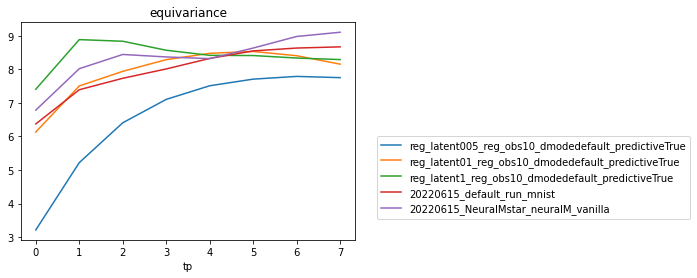

In [14]:
for mode in list(showresults):
    plt.plot(equiv_results[mode][0], label=mode.split('/')[-1])
    plt.xlabel("tp")
plt.legend(loc=0, bbox_to_anchor=(1.05, 0.5))
plt.title("equivariance")
plt.savefig(os.path.join(jobpath, targdir + 'equivariance.png'))


/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220907_latentPredict_0/reg_latent005_reg_obs10_dmodedefault_predictiveTrue 
 snapshot_model_iter_100000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220907_latentPredict_0/reg_latent01_reg_obs10_dmodedefault_predictiveTrue 
 snapshot_model_iter_100000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220907_latentPredict_0/reg_latent1_reg_obs10_dmodedefault_predictiveTrue 
 snapshot_model_iter_100000
/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result/20220615_default_run_mnist 
 snapshot_model_iter_50000


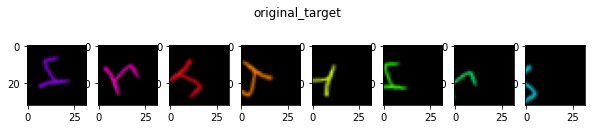

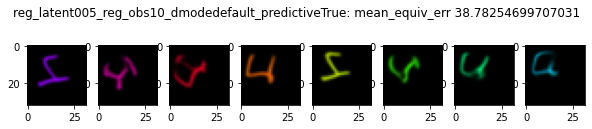

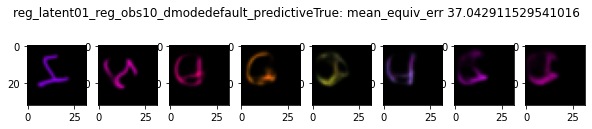

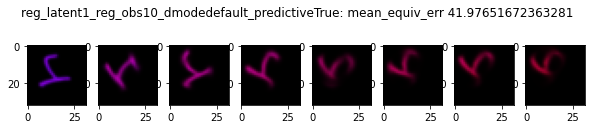

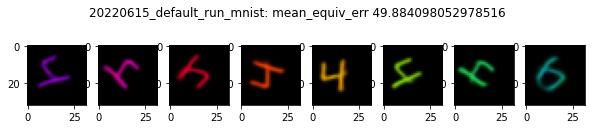

In [82]:
tp=8
idx = 0
#jobpath = os.path.join('../jobs/','_'.join(targdir.split('_')[:-1]))


images = data[idx]
if type(images) == list:
    images = torch.stack(images)
    images = images.unsqueeze(0)   
    images= images.to(device)

images_target = images[:, n_cond:n_cond+tp]

    
plt.figure(figsize =(10,2))
for k in range(0,tp):
    plt.subplot(1,tp, k+1)
    plt.imshow(images_target[0][k].detach().to('cpu').permute([1,2, 0]))
    
plt.suptitle(f"""original_target""")
plt.savefig(os.path.join(jobpath, f"""{targdir}_equiv_original.png"""))

for j in range(len(showresults)):
    x_next, M = get_predict(showresults[j], swap=True)
    name = showresults[j].split('/')[-1]
    plt.figure(figsize =(10,2))
    err = 0 
    for k in range(0,tp): 
        plt.subplot(1,tp, k+1)
        plt.imshow(x_next[0][k].detach().to('cpu').permute([1,2, 0]))
        err = err + torch.sum((x_next[0][k].to('cpu') - images_target[0][k].to('cpu'))**2)
    err = err / (k+1)
    plt.suptitle(f"""{name}: mean_equiv_err {err}""")
    plt.savefig(os.path.join(jobpath, f"""{targdir}_equiv_{name}.png"""))

In [32]:
x_next[0][k].shape

torch.Size([3, 32, 32])

In [85]:
os.listdir('/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result')

['20220825_Mstar_variation_0',
 '20220901_Mstar_inv_reg_cnn_0',
 '20220617_default_run_mnist_bg',
 '20220624_Mstar_longer_tp_neuralM_comm',
 '20220621_NeuralMstar_bg_neuralM_vanilla',
 '20220624_Mstar_longer_tp_neuralM_vanilla',
 '20220830_Mstar_orth_0',
 '20220826_Mstar_orth_mlp_two_0',
 '20220831_Mstar_orth_0',
 '20220630_NeuralMstar_comm_0',
 '20220830_Mstar_inv_reg_cnn_0',
 '20220617_NeuralMstar_bg_neuralM_comm',
 '20220628_NeuralMstar_comm_0',
 '20220829_Mstar_inv_reg_0',
 '20220621_NeuralMstar_bg_neuralM_comm',
 '20220816_so3_various_dat_three_0',
 '20220621_so3_rcst_so3run',
 '20220827_Mstar_orth_mlp_two_0',
 '20220615_default_run_mnist',
 '20220615_NeuralMstar',
 '20220615_NeuralMstar_neuralM_vanilla',
 '20220628_pfkube_try_0',
 '20220823_sine_dat_0',
 '20220908_latentPredict_bg_0',
 '20220701_so3_various_dat_three_0',
 '20220901_Mstar_orth_0',
 '20220630_longer_tp_0',
 '20220829_Mstar_inv_reg_cnn_0',
 '20220628_so3_idnet_0',
 '20220611_so3_so3run_rcst',
 '20220628_so3_various_